In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
adata = sc.read('annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 58015 × 14469
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'low_major', 'Cell_Type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'low_major_colors', 'neighbors', 'overcluster', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:


# Assuming your data is in adata.X (raw counts or normalized)
# Get expression values for both genes
rbp4_expr = adata[:, 'RBP4'].X
nts_expr = adata[:, 'NTS'].X

# If using sparse matrix, convert to array
if hasattr(rbp4_expr, 'toarray'):
    rbp4_expr = rbp4_expr.toarray().flatten()
    nts_expr = nts_expr.toarray().flatten()
else:
    rbp4_expr = rbp4_expr.flatten()
    nts_expr = nts_expr.flatten()

# Subset for cells expressing both genes (expression > 0)
coexpressing_cells = (rbp4_expr > 0) & (nts_expr > 0)
adata_subset = adata[coexpressing_cells, :]

print(f"Original cells: {adata.n_obs}")
print(f"Coexpressing cells: {adata_subset.n_obs}")

Original cells: 58015
Coexpressing cells: 170


In [6]:
adata_subset

View of AnnData object with n_obs × n_vars = 170 × 14469
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'low_major', 'Cell_Type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'low_major_colors', 'neighbors', 'overcluster', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [10]:
print(f"Conditions: {adata_subset.obs['condition'].value_counts().to_dict()}")
print(f"Locations: {adata_subset.obs['location'].value_counts().to_dict()}")

Conditions: {'Tumor': 170}
Locations: {'Left': 169, 'Right': 1}


Total coexpressing cells: 170


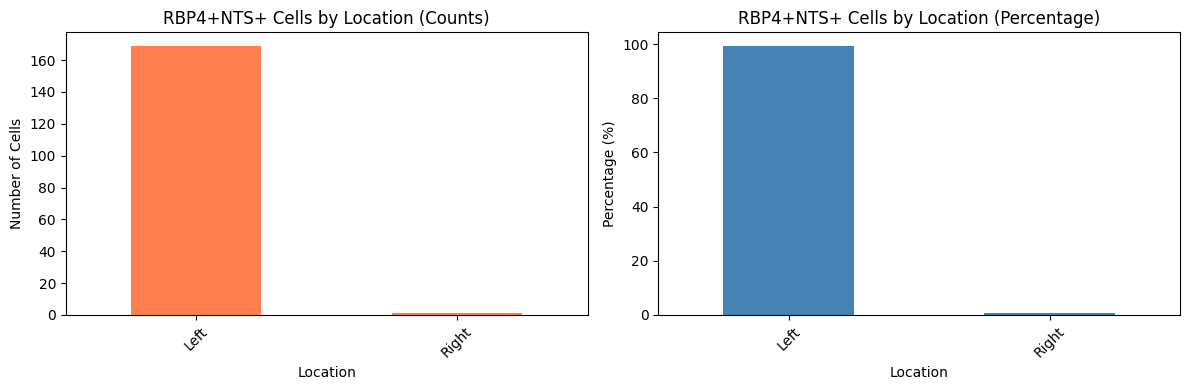


Distribution by location:
location
Left     169
Right      1
Name: count, dtype: int64

Percentages:
location
Left     99.411765
Right     0.588235
Name: proportion, dtype: float64


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the subset of coexpressing cells
rbp4_expr = adata[:, 'RBP4'].X
nts_expr = adata[:, 'NTS'].X

if hasattr(rbp4_expr, 'toarray'):
    rbp4_expr = rbp4_expr.toarray().flatten()
    nts_expr = nts_expr.toarray().flatten()
else:
    rbp4_expr = rbp4_expr.flatten()
    nts_expr = nts_expr.flatten()

coexpressing_cells = (rbp4_expr > 0) & (nts_expr > 0)
adata_subset = adata[coexpressing_cells, :]

print(f"Total coexpressing cells: {adata_subset.n_obs}")

# Visualize location distribution of coexpressing cells only
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Absolute counts
location_counts = adata_subset.obs['location'].value_counts()
location_counts.plot(kind='bar', ax=axes[0], color='coral')
axes[0].set_title('RBP4+NTS+ Cells by Location (Counts)')
axes[0].set_ylabel('Number of Cells')
axes[0].set_xlabel('Location')
axes[0].tick_params(axis='x', rotation=45)

# Proportions
location_props = adata_subset.obs['location'].value_counts(normalize=True) * 100
location_props.plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('RBP4+NTS+ Cells by Location (Percentage)')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Location')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary
print("\nDistribution by location:")
print(location_counts)
print("\nPercentages:")
print(location_props)

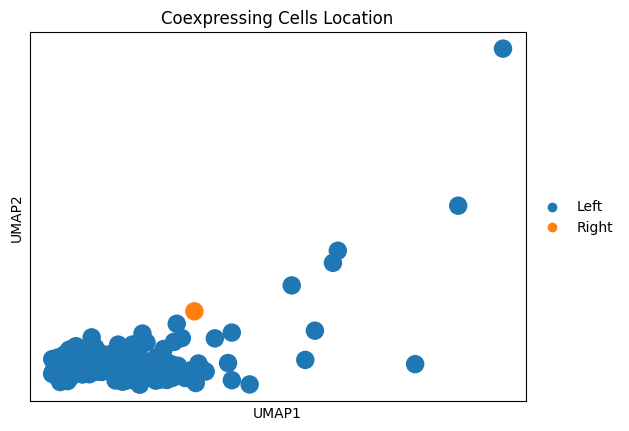

In [15]:


# Or highlight coexpressing cells
sc.pl.umap(adata[adata.obs['coexpresses_RBP4_NTS']], 
           color='location', 
           title='Coexpressing Cells Location')

In [16]:
subset=adata[(adata.obs['condition'] == 'Tumor')].copy()
subset

View of AnnData object with n_obs × n_vars = 43640 × 14469
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'low_major', 'Cell_Type', 'coexpresses_RBP4_NTS'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'low_major_colors', 'neighbors', 'overcluster', 'rank_genes_groups', 'umap', 'location_colors', 'coexpresses_RBP4_NTS_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [18]:
rbp4_expr = subset[:, 'RBP4'].X
nts_expr = subset[:, 'NTS'].X

if hasattr(rbp4_expr, 'toarray'):
    rbp4_expr = rbp4_expr.toarray().flatten()
    nts_expr = nts_expr.toarray().flatten()
else:
    rbp4_expr = rbp4_expr.flatten()
    nts_expr = nts_expr.flatten()

# Mark coexpressing cells
subset.obs['coexpresses_RBP4_NTS'] = (rbp4_expr > 0) & (nts_expr > 0)

In [23]:
# Create a crosstab
crosstab = pd.crosstab(subset.obs['location'], 
                       subset.obs['coexpresses_RBP4_NTS'],
                       margins=True)
print(crosstab)

# With percentages
crosstab_pct = pd.crosstab(subset.obs['location'], 
                           subset.obs['coexpresses_RBP4_NTS'],
                           normalize='index') * 100
print("\nPercentage by location:")
print(crosstab_pct)

coexpresses_RBP4_NTS  False  True    All
location                                
Left                  22679   169  22848
Right                 20791     1  20792
All                   43470   170  43640

Percentage by location:
coexpresses_RBP4_NTS      False     True 
location                                 
Left                  99.260329  0.739671
Right                 99.995190  0.004810
